In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('train.csv')

data.set_index('Id',inplace=True)

y = data.SalePrice
X_train = data.drop('SalePrice',axis=1)

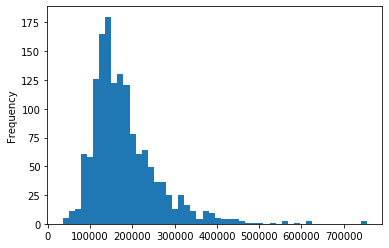

In [2]:
y.plot(kind='hist',bins=50)

In [3]:
#Convert target to log-normal distribution
y = np.log(y)

In [4]:
import seaborn as sns
num_cols = list(X_train.select_dtypes(include=np.number).columns)
num_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

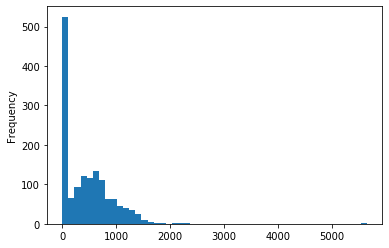

In [5]:
X_train['BsmtFinSF1'].plot(kind='hist',bins=50)
# np.log(X_train['GrLivArea']).plot(kind='hist',bins=50)

In [6]:
# #Write function to convert vars with lots of zeros to nans to impute later
# zero_val_cols = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
#              'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GarageArea',
#             'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
#             'ScreenPorch',]

# #Convert zeros to NaN to impute down the line
# for col in zero_val_cols:
#     X_train[col] = X_train[col].apply(lambda x:np.nan if (x == 0) else x)

In [7]:
#Log transform certain columns
log_trans_cols = ['LotArea','1stFlrSF','GrLivArea']

for col in log_trans_cols:
    X_train[col] = np.log(X_train[col])

In [8]:
rank_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
                      'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
                     'GarageCond',]

def rank_imputer(value):
    '''
    Convert cols with 5 ranks
    '''
    rank_map = {'ex':5,'gd':4,'ta':3,'fa':2,'po':1,np.nan:np.nan}
    try:
        return rank_map[value.lower()]
    except:
        return rank_map[value]

In [9]:
def bsmt_rank_imputer(value):
    '''
    Convert bsmtfintype columns
    '''
    rank_map = {'glq':6,'alq':5,'blq':4,
                'rec':3,'lwq':2,'unf':1,
                np.nan:np.nan}
    try:
        return rank_map[value.lower()]
    except:
        return rank_map[value]

In [10]:
bsmt_cols = ['BsmtFinType1','BsmtFinType2']
#Convert basement columns
for col in bsmt_cols:
    X_train[col] = X_train[col].apply(bsmt_rank_imputer)

In [11]:
#Convert 5 rank columns
for col in rank_cols:
    X_train[col] = X_train[col].apply(rank_imputer)

In [12]:
from sklearn.preprocessing import LabelEncoder

#Convert neighborhood column
lab_enc = LabelEncoder()
X_train['Neighborhood'] = lab_enc.fit_transform(X_train['Neighborhood'])

In [13]:
# #Find columns with greater than 90% missing values to drop entirely
# drop_cols = [col for col in X_train if 
#              X_train[col].isnull().sum()/len(X_train[col]) > 0.9]

# #Add miscval as useless without MiscFeature
# drop_cols.append('MiscVal')

# #Drop columns
# X_train.drop(drop_cols,axis=1,inplace=True)

In [14]:
# #Dropping the outlier rows with Percentiles
# upper_lim = X_train['LotArea'].quantile(.95)
# X_train.loc[(X_train['LotArea'] < upper_lim), 'LotArea'] = np.nan

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

cat_cols = [col for col in X_train.columns 
            if X_train[col].dtype == 'object' and
            X_train[col].nunique() <= 20]
num_cols = list(X_train.select_dtypes(include=np.number).columns)

my_cols = cat_cols + num_cols
X_train = X_train[my_cols].copy()

#Categorical Imputation
cat_imputer = Pipeline(steps = [
    ('imp',SimpleImputer(strategy='most_frequent')),
    ('OHE',OneHotEncoder(handle_unknown='ignore'))
])

#Numerical Imputation
num_imputer = SimpleImputer(strategy='mean')

#Bundled numerical and categorical transformer
transformer = ColumnTransformer(transformers = [
    ('num',num_imputer,num_cols),
    ('cat',cat_imputer,cat_cols)
])

X_train_mod = pd.DataFrame(transformer.fit_transform(X_train))

In [16]:
from sklearn.model_selection import cross_val_score, KFold

def score_model(model,X,y):
    '''
    Run CV on inputted model
    '''
    # CV model
    kfold = KFold(n_splits=5)
    results = np.sqrt(-1 * cross_val_score(model, X, y, 
                              cv=kfold, scoring='neg_mean_squared_error',
                                  verbose=False))
    #Mean Results
    return results.mean()

In [17]:
from lightgbm import LGBMRegressor

#Light GBM
lgb = LGBMRegressor(n_estimators=500,learning_rate=0.01)
lgb_result = score_model(lgb,X_train_mod,y)
print(f'\nLGBM: {lgb_result}')

/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)



LGBM: 0.13161389068211404


In [29]:
from sklearn.ensemble import GradientBoostingRegressor

#GBR
# gbr = GradientBoostingRegressor(n_estimators=500,learning_rate=0.1)
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber')
gbr_result = score_model(gbr,X_train_mod,y)
print(f'\nGBR: {gbr_result}')


GBR: 0.12171985433701897


In [19]:
from xgboost import XGBRegressor

#XGBoost
xgb = XGBRegressor(n_estimators=550,learning_rate=0.06)
xgb_result = score_model(xgb,X_train_mod,y)
print(f'XGB: {xgb_result}')

[14:01:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:01:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:01:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:01:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/morrell53/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:01:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.12571552801828792


In [24]:
from sklearn.ensemble import RandomForestRegressor

#Random Forest
rfr = RandomForestRegressor(n_estimators=100)
rfr_result = score_model(rfr,X_train_mod,y)
print(f'RFR: {rfr_result}')

RFR: 0.14099655206463005


In [25]:
from sklearn.linear_model import Lasso, Ridge

#Lasso Regression
las = Lasso(alpha=0.01)
las_result = score_model(las,X_train_mod,y)
print(f'Lasso: {las_result}')

#Ridge Regression
rid = Ridge()
rid_result = score_model(rid,X_train_mod,y)
print(f'Ridge: {rid_result}')

Lasso: 0.1595421260980054
Ridge: 0.14221357286396055


In [30]:
from mlxtend.regressor import StackingCVRegressor

#Stacking the various regressors initialized before
stack = StackingCVRegressor(regressors=(lgb,gbr,xgb ,rfr, las, rid),
                            meta_regressor= xgb, 
                            use_features_in_secondary=True)

#Fitting the data
stack_result = score_model(stack,np.array(X_train_mod),np.array(y))
print(f'Stack: {stack_result}')

[14:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [31]:
#Fit stack model
stack.fit(np.array(X_train_mod),np.array(y))

[14:44:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:45:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:46:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.06,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=550,
                                                n_jobs=1, nthread=None,
                                                objective='reg:linear',
                                                random_state=0, reg_alpha=0,
                                          

In [27]:
#Load test data
test = pd.read_csv('test.csv')

test.set_index('Id',inplace=True)

#Convert 5 rank columns
for col in rank_cols:
    test[col] = test[col].apply(rank_imputer)

#Convert basement columns
for col in bsmt_cols:
    test[col] = test[col].apply(bsmt_rank_imputer)
    
#Convert neighborhood column
test['Neighborhood'] = lab_enc.transform(test['Neighborhood'])

#Log transform non-normal cols
for col in log_trans_cols:
    test[col] = np.log(test[col])

In [28]:
test = test[my_cols].copy()
test_mod = pd.DataFrame(transformer.transform(test))

In [32]:
predictions = stack.predict(np.array(test_mod))

In [39]:
np.exp(y)

Id
1       208500.0
2       181500.0
3       223500.0
4       140000.0
5       250000.0
          ...   
1456    175000.0
1457    210000.0
1458    266500.0
1459    142125.0
1460    147500.0
Name: SalePrice, Length: 1460, dtype: float64

In [40]:
#Convert predictions so not lognormal
final_predictions = np.exp(predictions)

#Save final predictions for submission
submission11 = pd.DataFrame(final_predictions,index=test.index,columns=['SalePrice'])
submission11.to_csv(r'Stacking_v1.csv',index=True)

In [41]:
submission11.head()

,SalePrice
Id,
1461,120190.656250
1462,163468.953125
1463,183446.531250
1464,194069.578125
1465,174105.078125
